In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [1]:
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/moderate-imbalance-leukemia/Moderate imbalance'

# Define paths for the train and test sets
train_dir = {
    'all': os.path.join(original_dataset_dir, 'Train', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Train', 'hem')
}
test_dir = {
    'all': os.path.join(original_dataset_dir, 'Test', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Test', 'hem')
}

# Define the working directory to copy the dataset
working_dir = '/kaggle/working/imbalance-leukemia/High_imbalance'

# Create the target directories in the working directory if they don't exist
os.makedirs(os.path.join(working_dir, 'Train', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Train', 'hem'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'hem'), exist_ok=True)

# Copy data from the original dataset to the working directory
try:
    shutil.copytree(train_dir['all'], os.path.join(working_dir, 'Train', 'all'), dirs_exist_ok=True)
    shutil.copytree(train_dir['hem'], os.path.join(working_dir, 'Train', 'hem'), dirs_exist_ok=True)
    shutil.copytree(test_dir['all'], os.path.join(working_dir, 'Test', 'all'), dirs_exist_ok=True)
    shutil.copytree(test_dir['hem'], os.path.join(working_dir, 'Test', 'hem'), dirs_exist_ok=True)
    print("Files copied successfully!")
except Exception as e:
    print(f"Error during copying: {e}")

# Define the LeukemiaDataset class
class LeukemiaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Iterate over all subdirectories (all, hem) and get the images
        for label, sub_dir in enumerate(['all', 'hem']):
            class_dir = os.path.join(data_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the paths for the new train and test sets in the working directory
train_dir_working = {
    'all': os.path.join(working_dir, 'Train', 'all'),
    'hem': os.path.join(working_dir, 'Train', 'hem')
}
test_dir_working = {
    'all': os.path.join(working_dir, 'Test', 'all'),
    'hem': os.path.join(working_dir, 'Test', 'hem')
}

# Load train and test datasets from the working directory
train_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Train'), transform=train_transform)
test_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Test'), transform=val_test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to count the number of files in each directory
def count_files_in_dir(directory):
    file_count = 0
    for sub_dir in ['all', 'hem']:  # Check both 'all' and 'hem' directories
        class_dir = os.path.join(directory, sub_dir)
        if os.path.exists(class_dir):
            file_count += len(os.listdir(class_dir))  # Count files in the sub-directory
    return file_count

# Count files in the training and testing datasets
train_file_count = count_files_in_dir(os.path.join(working_dir, 'Train'))
test_file_count = count_files_in_dir(os.path.join(working_dir, 'Test'))

# Print the counts
print(f"Training set - Total files: {train_file_count}")
print(f"Testing set - Total files: {test_file_count}")


Files copied successfully!
Training set - Total files: 110
Testing set - Total files: 60


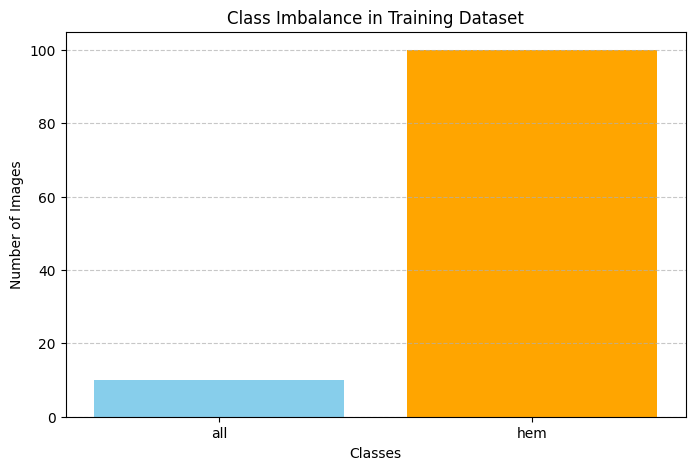

In [2]:
import matplotlib.pyplot as plt

# Function to count the number of images per class
def count_class_distribution(directory):
    class_counts = {}
    for class_name in ['all', 'hem']:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
        else:
            class_counts[class_name] = 0
    return class_counts

# Count class distribution for training set
train_class_counts = count_class_distribution(os.path.join(working_dir, 'Train'))

# Plotting the class distributions for training set
def plot_train_class_distribution(train_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, train_values, color=['skyblue', 'orange'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Imbalance in Training Dataset')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot the graph
plot_train_class_distribution(train_class_counts)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

In [5]:
class GhostNet(nn.Module):
    def __init__(self, num_classes):
        super(GhostNet, self).__init__()
        # Initialize GhostNet without pre-trained weights
        self.base_model = timm.create_model('ghostnet_100', pretrained=False, num_classes=num_classes)
        self.features = self.base_model.forward_features  # Feature extraction part
        
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(960, num_classes)  # Final classifier (960 channels)

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.pool(x)  # Global average pooling
        x = torch.flatten(x, 1)  # Flatten for classification
        x = self.fc(x)  # Final classification
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2

model = GhostNet(num_classes=num_classes) 

model.to(device)
print(model)

GhostNet(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (primary_co

In [16]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [18]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history


In [25]:
from tqdm import tqdm  # Import tqdm for progress bars

# Train the model
num_epochs = 50
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=num_epochs)


Epoch 1/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0821 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Val Loss: 0.9621 Acc: 0.5833

Epoch 2/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.1319 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Val Loss: 0.9477 Acc: 0.5833

Epoch 3/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.0944 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Val Loss: 1.0139 Acc: 0.5833

Epoch 4/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.0944 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


Val Loss: 0.9633 Acc: 0.5833

Epoch 5/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Train Loss: 0.1505 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Val Loss: 0.9986 Acc: 0.5833

Epoch 6/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.1052 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Val Loss: 0.9533 Acc: 0.5833

Epoch 7/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Train Loss: 0.0683 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Val Loss: 0.9664 Acc: 0.5833

Epoch 8/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Train Loss: 0.0889 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Val Loss: 0.9818 Acc: 0.5833

Epoch 9/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1060 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Val Loss: 0.9859 Acc: 0.5833

Epoch 10/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Train Loss: 0.1087 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Val Loss: 0.9475 Acc: 0.5833

Epoch 11/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Train Loss: 0.1111 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


Val Loss: 0.9393 Acc: 0.6000

Epoch 12/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Train Loss: 0.1145 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


Val Loss: 0.9290 Acc: 0.6000

Epoch 13/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Train Loss: 0.0830 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Val Loss: 0.9295 Acc: 0.6000

Epoch 14/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Train Loss: 0.1054 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Val Loss: 0.9545 Acc: 0.5667

Epoch 15/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0948 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Val Loss: 0.9582 Acc: 0.5833

Epoch 16/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.0911 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


Val Loss: 0.9688 Acc: 0.5833

Epoch 17/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Train Loss: 0.1333 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Val Loss: 0.9315 Acc: 0.6000

Epoch 18/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Train Loss: 0.0983 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Val Loss: 0.9388 Acc: 0.6000

Epoch 19/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Train Loss: 0.1347 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Val Loss: 0.9037 Acc: 0.5833

Epoch 20/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Train Loss: 0.1153 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


Val Loss: 0.9341 Acc: 0.5833

Epoch 21/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Train Loss: 0.0908 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Val Loss: 0.9649 Acc: 0.5667

Epoch 22/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.1179 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Val Loss: 0.9388 Acc: 0.5667

Epoch 23/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.1133 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Val Loss: 0.9738 Acc: 0.5667

Epoch 24/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Train Loss: 0.1193 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


Val Loss: 0.9744 Acc: 0.5667

Epoch 25/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.1163 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Val Loss: 0.9372 Acc: 0.5833

Epoch 26/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Train Loss: 0.0855 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


Val Loss: 0.9388 Acc: 0.5833

Epoch 27/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Train Loss: 0.1182 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Val Loss: 0.9622 Acc: 0.5667

Epoch 28/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0974 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Val Loss: 0.9129 Acc: 0.5833

Epoch 29/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Train Loss: 0.0863 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


Val Loss: 0.9115 Acc: 0.5833

Epoch 30/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.1591 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Val Loss: 0.8509 Acc: 0.6500

Epoch 31/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Train Loss: 0.1355 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Val Loss: 0.9099 Acc: 0.5833

Epoch 32/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1187 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Val Loss: 0.9092 Acc: 0.5833

Epoch 33/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.1154 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


Val Loss: 0.9384 Acc: 0.5667

Epoch 34/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


Train Loss: 0.1606 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


Val Loss: 1.0000 Acc: 0.5833

Epoch 35/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Train Loss: 0.0974 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Val Loss: 0.9769 Acc: 0.5667

Epoch 36/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Train Loss: 0.1266 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


Val Loss: 1.0025 Acc: 0.5667

Epoch 37/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Train Loss: 0.1115 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Val Loss: 0.9487 Acc: 0.5667

Epoch 38/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.1345 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


Val Loss: 0.9003 Acc: 0.6167

Epoch 39/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0941 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Val Loss: 0.9768 Acc: 0.5833

Epoch 40/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Train Loss: 0.0878 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Val Loss: 0.9754 Acc: 0.5833

Epoch 41/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Train Loss: 0.0998 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Val Loss: 0.9867 Acc: 0.5833

Epoch 42/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1235 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Val Loss: 0.9814 Acc: 0.5833

Epoch 43/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Train Loss: 0.1182 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Val Loss: 0.9814 Acc: 0.5833

Epoch 44/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Train Loss: 0.1105 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Val Loss: 0.9610 Acc: 0.5833

Epoch 45/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0736 Acc: 0.9818


Val: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Val Loss: 0.9371 Acc: 0.6167

Epoch 46/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0951 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]


Val Loss: 0.8963 Acc: 0.6333

Epoch 47/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Train Loss: 0.1006 Acc: 0.9636


Val: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Val Loss: 0.9098 Acc: 0.5833

Epoch 48/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Train Loss: 0.0717 Acc: 0.9727


Val: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Val Loss: 0.8615 Acc: 0.6500

Epoch 49/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Train Loss: 0.0977 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Val Loss: 0.9314 Acc: 0.6000

Epoch 50/50
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Train Loss: 0.1213 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

Val Loss: 0.9673 Acc: 0.5833

Best Validation Acc: 0.6500


Testing: 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


Classification Report:
              precision    recall  f1-score   support

         All       0.86      0.20      0.32        30
         Hem       0.55      0.97      0.70        30

    accuracy                           0.58        60
   macro avg       0.70      0.58      0.51        60
weighted avg       0.70      0.58      0.51        60



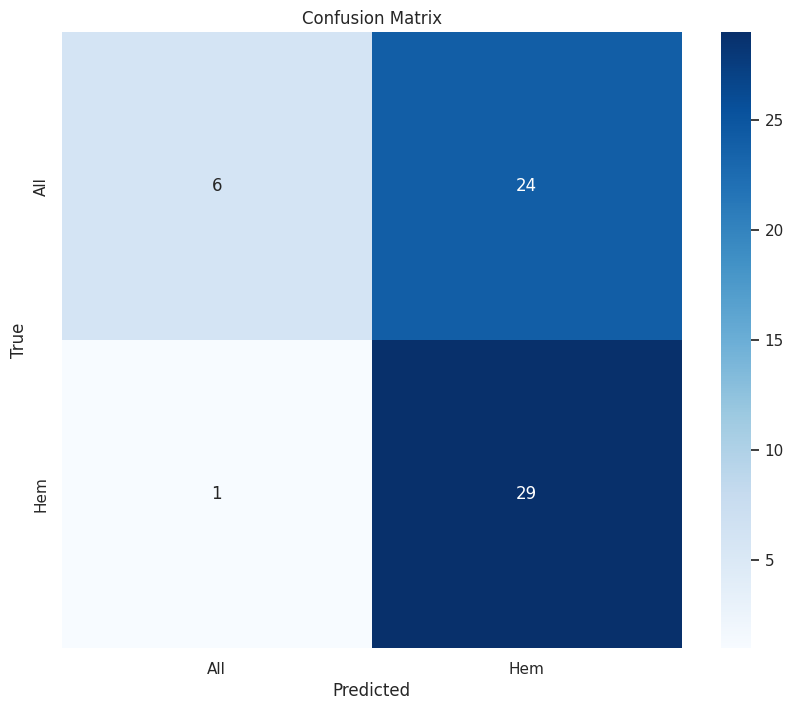

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['All', 'Hem'])

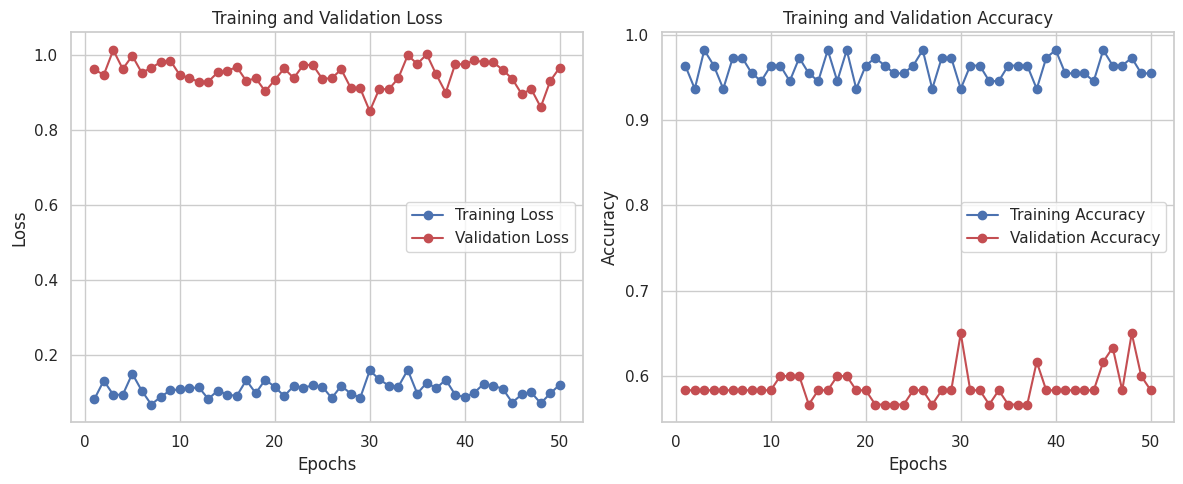

In [27]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


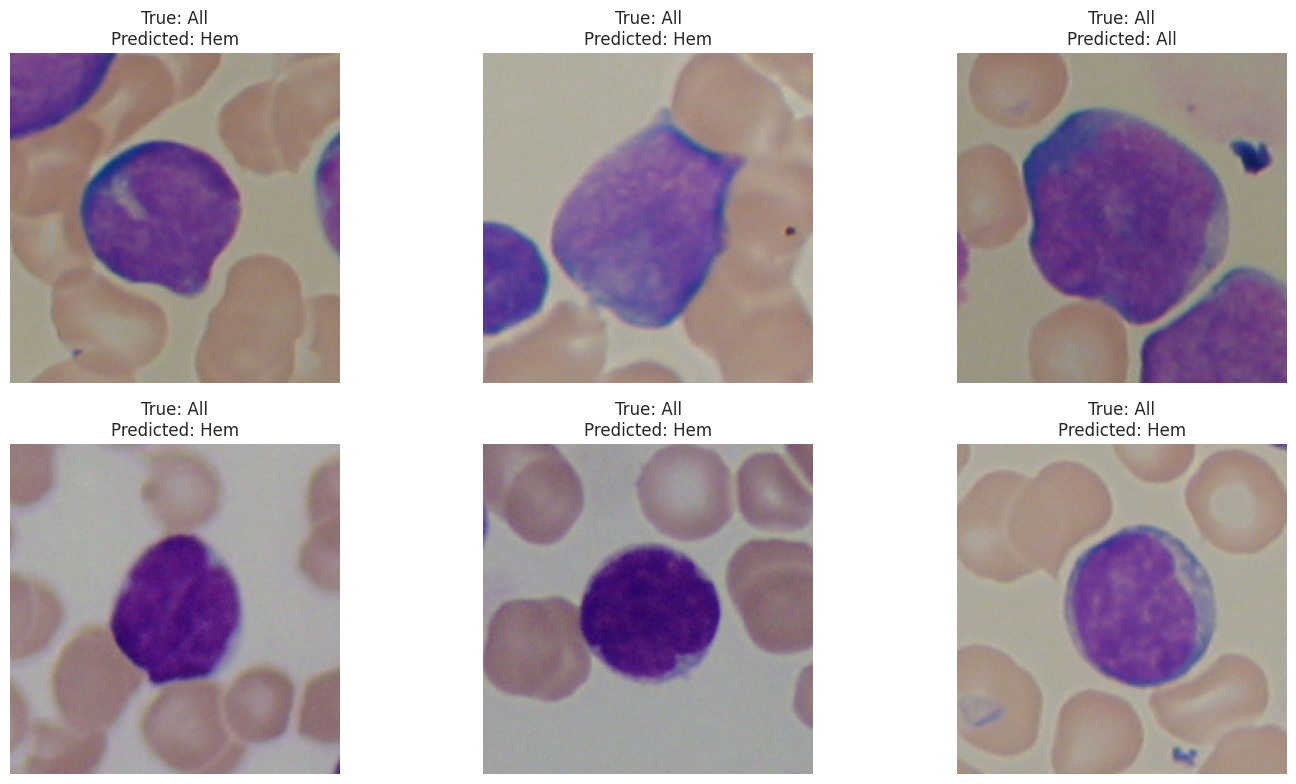

In [28]:
import numpy as np
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['All', 'Hem'], num_images=6)
